In [1]:
from typing import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, classification_report

%load_ext autoreload
%autoreload 1
%aimport helpers
from helpers import get_top_values, get_bottom_values

## Load data
We will use the DataFrame constructed in `Data_Preprocessing.ipynb`. It contains reviews of restaurants from Las Vegas from approximately the last 2 years.

In [2]:
br = pd.read_csv('preprocessed.csv')
br.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124693 entries, 0 to 124692
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    124693 non-null  int64  
 1   business_id   124693 non-null  object 
 2   name          124693 non-null  object 
 3   postal_code   124690 non-null  float64
 4   stars_x       124693 non-null  float64
 5   review_count  124693 non-null  int64  
 6   attributes    124487 non-null  object 
 7   review_id     124693 non-null  object 
 8   user_id       124693 non-null  object 
 9   stars_y       124693 non-null  float64
 10  useful        124693 non-null  int64  
 11  funny         124693 non-null  int64  
 12  cool          124693 non-null  int64  
 13  text          124693 non-null  object 
 14  date          124693 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 14.3+ MB


In [3]:
br.head()

,Unnamed: 0,business_id,name,postal_code,stars_x,review_count,attributes,review_id,user_id,stars_y,useful,funny,cool,text,date
0,0,AN0bWhisCf6LN9eHZ7DQ3w,Los Olivos Ristorante,89121.0,5.0,222,"{'WiFi': ""u'free'"", 'RestaurantsPriceRange2': ...",htSvAB0GEPZOdvebmVqg4g,GgCjStvmclW9uedJa_tTlA,5.0,1,0,0,"Very good restaurant, they have many choices a...",2018-09-03 02:54:29
1,1,AN0bWhisCf6LN9eHZ7DQ3w,Los Olivos Ristorante,89121.0,5.0,222,"{'WiFi': ""u'free'"", 'RestaurantsPriceRange2': ...",yoXlN_RAJAVuhvR4lLs_nw,4CR7rQLHuXZpfLzDvqlaIA,5.0,0,1,1,Awsome little Italian place. Never would have ...,2018-06-19 17:20:53
2,2,AN0bWhisCf6LN9eHZ7DQ3w,Los Olivos Ristorante,89121.0,5.0,222,"{'WiFi': ""u'free'"", 'RestaurantsPriceRange2': ...",sjGYJKxxNtKcFeZHwjfYLg,UkBp300T1dfvMK8BLq08qQ,5.0,0,0,0,We moved back to Vegas about a year ago and he...,2018-08-05 03:13:21
3,3,AN0bWhisCf6LN9eHZ7DQ3w,Los Olivos Ristorante,89121.0,5.0,222,"{'WiFi': ""u'free'"", 'RestaurantsPriceRange2': ...",3ccPyWbmFfR8T-Ev3qQDcg,IyQGS915aIQcwPtSwKLI8w,5.0,0,0,0,We came to Los Olivos to have our Festa Di Nat...,2017-12-16 15:10:08
4,5,AN0bWhisCf6LN9eHZ7DQ3w,Los Olivos Ristorante,89121.0,5.0,222,"{'WiFi': ""u'free'"", 'RestaurantsPriceRange2': ...",AtuHkK0K5EpYUSF1qhB8bw,nmhOSjQnKSytS-ztuGdIow,5.0,0,0,0,"I don't normally yelp about places to eat, but...",2018-08-24 06:09:25


In [4]:
linear = br[['stars_x','stars_y','review_count','useful','funny','cool']].corr()

In [5]:
# sns.heatmap(linear)

# plt.title("Linear Relations among Variables")

So the 'useful','funny' and 'cool' data have strong linear correlations with each other. This is not surprising considering that they are all indications of how many people liked any given post.
Indicates that we can pick EITHER ONE to weigh the importance of each review.

Text(0, 0.5, 'Number of Reviews')

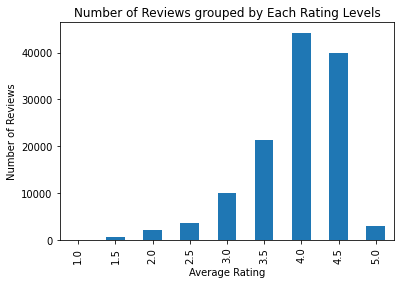

In [6]:
br.stars_x.value_counts().sort_index().plot.bar()

plt.title('Number of Reviews grouped by Each Rating Levels')
plt.xlabel('Average Rating')
plt.ylabel('Number of Reviews')

So reviews are concentrated around 4.0 rating
It shows that users generally refrain from giving extreme reviews, good or bad

Now that we have some idea of what the data looks like, we can start the NLP part of this project

# NLP

## Extract review texts

Convert the values of the 'text' column into a variable called "documents"

In [7]:
documents = br.text

We can then explore this variable(e.g. check lengths of reviews)

Text(0.5, 0, 'Length of Reviews(characters)')

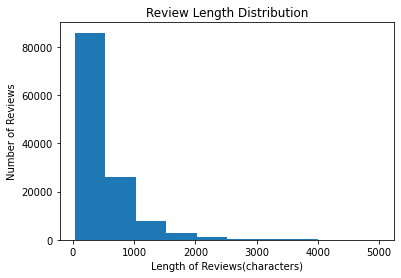

In [8]:
plt.hist(documents.apply(len))
plt.title('Review Length Distribution')
plt.ylabel('Number of Reviews')
plt.xlabel('Length of Reviews(characters)')

In [9]:
print('There are {} reviews in total.'.format(len(documents)))
print('Sample:{}'.format(documents[0]))

There are 124693 reviews in total.
Sample:Very good restaurant, they have many choices and they are willing to meet your needs.
We are vegan and we were with a big party of omnivores, but they had no problem to cook something just for us.


## Define Target Variable

We chose to distinguish between perfect (5 stars) and imperfect (1-4 stars) ratings. The assumption is that any rating under a 5 indicates that there is room for improvement.

In [10]:
target = br.stars_y
target = (target == 5) #Returns True if perfect
target = target.astype('int')

In [11]:
target.value_counts()

1    67160
0    57533
Name: stars_y, dtype: int64

Fortunately, target variable is not too imbalanced

## Split data into training and test sets

In [12]:
from sklearn.model_selection import train_test_split

documents_train,documents_test,target_train,target_test = train_test_split(documents,target,test_size=0.2,random_state = 49)

## Obtain NLP representation of `documents`

Here I will tokenize reviews as unigrams, and convert each review to a term frequency–inverse document frequency (Tf-idf) vector.

In [13]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
def get_n_most_frequent_tokens(reviews: Iterable[str], 
                               n: int = 20, 
                               max_df: float = 0.98) -> Iterable[Tuple[str, int]]:
    """ Get the n-most frequent unigrams, given a document-frequency cap """
    
    count_vec = CountVectorizer(max_df=max_df)
    per_token_counts = np.asarray(count_vec.fit_transform(reviews).sum(axis=0))[0]
    ix_to_token = {ix:tk for tk, ix in count_vec.vocabulary_.items()}
        
    i = 0    
    for token_ix in reversed(np.argsort(per_token_counts)):
        if i < n:
            i += 1
            yield ix_to_token[token_ix], per_token_counts[token_ix]

In [15]:
top_n_words = pd.DataFrame(get_n_most_frequent_tokens(documents_train, 30, 0.98), 
                           columns=["tokens", "counts"])
top_n_words

,tokens,counts
0,the,484784
1,and,336209
2,to,204453
3,was,200725
4,it,145639
5,of,122077
6,is,113547
7,for,107628
8,we,106687
9,in,93649


23rd token is 'good'; 26th is great: clearly relevant to sentiment, gotta keep

In [17]:
rev_stop_words = top_n_words["tokens"].iloc[0:22].values

all_stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 
                  'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 
                  'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was',
                  'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 
                  'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 
                  'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 
                  'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 
                  'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', 
                  "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 
                  'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 
                  'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 
                  'wouldn', "wouldn't"] + rev_stop_words.tolist()

In [150]:
# Create TfidfVectorizer, and name it vectorizer
vectorizer = TfidfVectorizer(lowercase=True, stop_words=all_stop_words, 
                             max_df=0.9, ngram_range=(1,2), min_df=0.01)

In [151]:
# Fit the vectorizer with training data
X_train = vectorizer.fit_transform(documents_train)

# Use the trained vectorizer to transform test data
X_test = vectorizer.transform(documents_test)

In [152]:
X_train.shape[1]

806

In [153]:
#Get vocab of tfidf
tokens_to_ix = vectorizer.vocabulary_
ix_to_tokens = {ix:token for token, ix in tokens_to_ix.items()}

#print(vocab) #{words:column number}
#Get count of total vocabs
print('Vocabulary contains {} words when using unigram'.format(len(tokens_to_ix)))

Vocabulary contains 806 words when using unigram


## Classify positive/negative review

Three classification models attempted:

1. Logistic regression: coefficients are easy to interpret. Would help us understand the language.
2. naive Bayes classifier: Training and running are very quick, and performs reasonably well
3. Random Forest: build and tune more complex model for even higher accuracy

We use accuracy as our metric, because the classes are almost balanced

In [154]:
#Logistic Regression: no parameters to tune, because classes are almost balanced

from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver='lbfgs',max_iter=200) #lbfgs is for multinominal classifcation
lr_clf.fit(X_train, target_train)

LogisticRegression(max_iter=200)

In [155]:
#Mean accuracy for training set
lr_clf.score(X_train, target_train)

0.8449786474727831

In [156]:
#Mean accuracy for test set
lr_clf.score(X_test, target_test)

0.8361201331248246

This is a pretty good accuracy score (above 80%) for such a simple model. Even though the classes are mostly balanced, we will check errors and F1 score just in case.

In [157]:
confusion_matrix(target_test,lr_clf.predict(X_test),normalize='true')

array([[0.80109489, 0.19890511],
       [0.13386941, 0.86613059]])

In [158]:
print(classification_report(target_test, lr_clf.predict(X_test), target_names=("Imperfect", "Perfect")))

              precision    recall  f1-score   support

   Imperfect       0.84      0.80      0.82     11508
     Perfect       0.84      0.87      0.85     13431

    accuracy                           0.84     24939
   macro avg       0.84      0.83      0.83     24939
weighted avg       0.84      0.84      0.84     24939



Precision, recall, f1-score all above 80%. Awesome!

#### (Multinomial) Naive Bayes Classifier
Technically multinomial naive Bayes should be fed integer features, but according to [sklearn's documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) fractional tf-idf values work in practice, too. 

In [159]:
from sklearn.naive_bayes import MultinomialNB

nb_clf = MultinomialNB(alpha=1.0, fit_prior=True)
nb_clf.fit(X_train, target_train)

MultinomialNB()

In [160]:
#Accuracy for training set
nb_clf.score(X_train, target_train)

0.8200773903803357

In [161]:
#Accuracy for test set
nb_clf.score(X_test, target_test)

0.8151890613095955

This accuracy score is not bad! It is quick to run and so definitely worth considering

## Cross validate, and (hopefully) find an even better classifier

Linear classifers, i.e. logistic regression and naive Bayes, are already performing quite alright with 80%+ accuracy. Let's see if we can do even better using more complicated, non-linear classifiers. Random forest in this case.

Random search is preferred over grid search when each iteration takes a long time; that *will* be the case with random forests. Hence, I am searching over randomly generated `max_depth` and `max_features`. In addition, I would like to cap `n_estimators` at 60, as a further measure to save time; the manually defined values should be spread-out enough to identify which region works the best.

In [162]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier

# #For reproduceable experiments
# np.random.seed(5)

# #Test different possibilities of max_features up until the actual number of features
# total_number_of_features = X_train.shape[1]
# log10_total_numbers_of_features = np.log10(total_number_of_features)
# max_features = np.ceil(np.power(10,np.random.random(size=5)*log10_total_numbers_of_features)).astype(int)

# #Check to make sure there are no duplicates
# print(max_features)

In [163]:
# #Try different max_depths for trees:considering the number of features, we need deeper trees
# max_depth = np.random.choice(range(10,50),size=5,replace=False) 
# print(max_depth)

In [164]:
# #Parameter tuning using grid search
# rf_paramgrid = {
#     'max_depth': max_depth,
#     'n_estimators': (25,30,60), #For the sake of running speed, I'm limiting the no. of trees to 40
#     'max_features': max_features
# }

# grid_rf = GridSearchCV(cv=3,
#                        estimator=RandomForestClassifier(),
#                       param_grid=rf_paramgrid,
#                       scoring='accuracy', n_jobs=2)

# grid_rf.fit(X_train, target_train)

In [165]:
# print('After 3-fold randomized CV, Random Forest achieves a mean accuracy of {}'.format(grid_rf.best_score_))
# print('The training accuracy is {}'.format(grid_rf.score(X_train, target_train)))

In [166]:
# #Check the hyperparameters found
# print(grid_rf.best_params_)

In [167]:
# #Fine tuning around the parameter set found above

# rf_paragrid_finetune = {
#      'max_depth': (34, 37, 40),
#     'n_estimators': (100,),
#     'max_features': (1800, 1900, 1952, 2000),
# }

# grid_rf_finetune = GridSearchCV(cv=3, 
#                                 estimator=RandomForestClassifier(), 
#                                 param_grid=rf_paramgrid_finetune, 
#                                 scoring='accuracy', n_jobs=2)

# grid_rf_finetune.fit(X_train, target_train)

In [168]:
# print(grid_rf_finetune.best_params_)

In [169]:
# print("After fine tuning, random forest achieves a mean accuracy of {} on 3-fold CV".format(grid_rf_finetune.best_score_))
# print("The train accuracy is {}".format(grid_rf_finetune.score(X_train, target_train)))
# print("The test accuracy is {}".format(grid_rf_finetune.score(X_test, target_test)))

## What can we do with the models?
How can we make use of the sentiment analysis models trained above? Admittedly, for Yelp reviews, it doesn't seem necessary to predict a label for each review, because each review is already associated with a star rating. (In fact, that's how we got our labels.)

However, one can imagine wanting to classify text reviews coming from outside Yelp; in this case, the enormous Yelp data set is great for building a baseline model.

Then, for instance, given a corpus of unlabeled reviews for e.g. new restaurants, the models allow us to quickly estimate e.g. the proportion of positive/negative reviews. Demonstrated below using Yelp data.

In [170]:
most_reviewed_restaurants = br.groupby("business_id")\
                              ["review_id"].nunique()\
                                           .sort_values(ascending=False)

In [171]:
pos_rev_df = []

for bid in most_reviewed_restaurants.index[0:5]:
    # For each business_id (bid)
    # predict sentiment of associated reviews
    # then compute the predicted proportion of +ve reviews
    df_bid = br.query("`business_id` == @bid")
    
    reviews_bid = vectorizer.transform(df_bid["text"])
    predicted_sentiments = lr_clf.predict(reviews_bid)
    positive_review_proportion = (predicted_sentiments == True).sum() / predicted_sentiments.shape[0]
    
    restaurant_name = df_bid["name"].iloc[0]
    pos_rev_df.append((restaurant_name, positive_review_proportion))
    
pos_rev_df = pd.DataFrame(pos_rev_df, columns=["Restaurant", "Proportion of Positive Reviews"])\
               .set_index("Restaurant")

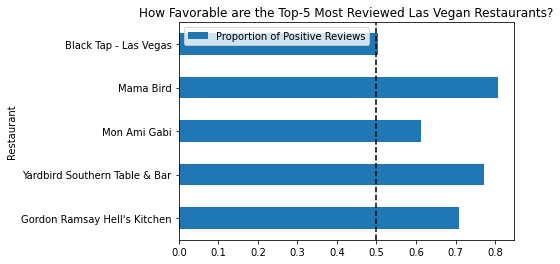

In [172]:
# For the most-reviewed restaurant, Tom's Urban, number of reviews with negative sentiment
# outnumbers positive ones!

pos_rev_df.plot.barh(title="How Favorable are the Top-5 Most Reviewed Las Vegan Restaurants?")
plt.axvline(0.5, ls="--", color="black")

In [195]:
poor = br.loc[ (br["stars_y"]==1) | (br["stars_y"] == 2)]

In [198]:
poor_vec = vectorizer.transform(poor.text)

#### Q: Which features (words) that tend to produce a positive/negative prediction?

Glad to see that features with the most positive/negative coefficients in logistic regression actually correspond to positive/negative sentiments! (Remember, positive = 1, negative = 0) 

In [173]:
#Identify the words relevant to predicting positive/negative reviews

top_positive_words = get_top_values(lst=lr_clf.coef_[0], n=50, labels=ix_to_tokens)
print(top_positive_words)

top_negative_words = get_bottom_values(lst=lr_clf.coef_[0], n=50, labels=ix_to_tokens)
print(top_negative_words)

['amazing', 'best', 'delicious', 'thank', 'incredible', 'awesome', 'excellent', 'phenomenal', 'perfect', 'favorite', 'outstanding', 'fantastic', 'perfection', 'wow', 'great', 'perfectly', 'gem', 'everything', 'highly', 'every', 'wonderful', 'omg', 'bomb', 'love', 'knowledgeable', 'beyond', 'world', 'glad', 'loved', 'die', 'exceptional', 'mouth', 'thanks', 'disappoint', 'oh', 'welcoming', 'definitely back', 'happy', 'helpful', 'must', 'life', 'five', 'vegas', 'greeted', 'love place', 'definitely', 'even though', 'friendly', 'ever', 'immediately']
['worst', 'rude', 'terrible', 'bland', 'horrible', 'disappointing', 'ok', 'poor', 'mediocre', 'okay', 'dry', 'however', 'overpriced', 'slow', 'average', 'reason', 'unfortunately', 'decent', 'dirty', 'overall', 'bad', 'cold', 'guess', 'nothing', 'salty', 'told', 'seemed', 'maybe', 'money', 'asked', 'star', 'said', 'would', 'sad', 'though', 'happened', 'tasted like', 'sorry', 'paid', 'charge', 'hour', 'loud', 'bill', 'bit', 'looked', 'seem', 'sta

## Cluster Reviews with KMeans

Fit K-means clustering with training data, and then apply it on the entire dataset. Tune with elbow method.
Used sklearn.cluster.MiniBatchKMeans isntead of sklearn.cluster.KMeasn to speed up convergence

In [174]:
from sklearn.cluster import MiniBatchKMeans


In [175]:
# Predict positive/negative label for reviews in test set
y_pred = lr_clf.predict(X_test)

# Extract only those reviews predicted to be negative
negative_documents = documents_test.loc[y_pred == False]  # raw text
negative_X_test = X_test[y_pred == False]  # tfidf vectors

In [199]:
# kmeans_model = MiniBatchKMeans(9).fit(negative_X_test)
kmeans_model = MiniBatchKMeans(9).fit(poor_vec)

In [200]:

#Define function to print top features (largest component of the centroid vector) of each cluster

def print_top_n_features(model: MiniBatchKMeans, ix_to_tokens: Dict[int, str], n: int=10):
    cluster_centers = model.cluster_centers_
    labels = model.labels_
    
    for i, centroid in enumerate(cluster_centers):
        top_n_features = np.argsort(centroid)[::-1][:n]
        top_n_words = [ix_to_tokens[feature_index] for feature_index in top_n_features]
        
        print('Top tokens from cluster {} (# of obs: {})'.format(i, (labels==i).sum()))
        print(top_n_words)

In [202]:
for review in poor.loc[kmeans_model.labels_ == 0]:
    print(review)
    break

Unnamed: 0


In [203]:
print_top_n_features(kmeans_model, ix_to_tokens, 10)

Top tokens from cluster 0 (# of obs: 3760)
['good', 'better', 'ordered', 'like', 'bland', 'buffet', 'flavor', 'taste', 'steak', 'would']
Top tokens from cluster 1 (# of obs: 1224)
['worst', 'ever', 'never', 'place', 'service', 'one', 'like', 'even', 'order', 'experience']
Top tokens from cluster 2 (# of obs: 7174)
['place', 'like', 'time', 'go', 'get', 'even', 'good', 'back', 'money', 'never']
Top tokens from cluster 3 (# of obs: 1518)
['chicken', 'ordered', 'like', 'dry', 'good', 'got', 'fried', 'place', 'order', 'fries']
Top tokens from cluster 4 (# of obs: 1141)
['bad', 'service', 'place', 'like', 'good', 'never', 'really', 'time', 'order', 'go']
Top tokens from cluster 5 (# of obs: 1477)
['customer', 'customer service', 'service', 'rude', 'order', 'manager', 'never', 'horrible', 'us', 'location']
Top tokens from cluster 6 (# of obs: 3608)
['order', 'pizza', 'said', 'asked', 'told', 'manager', 'get', 'never', 'back', 'ordered']
Top tokens from cluster 7 (# of obs: 986)
['horrible', 

In [180]:
#Start with k=3, as a trial
kmeans = MiniBatchKMeans(n_clusters=3, batch_size=500, max_iter=100, n_init=5)
kmeans.fit(X_train)
print_top_n_features(kmeans,ix_to_tokens,n=10)

Top tokens from cluster 0 (# of obs: 64955)
['good', 'place', 'like', 'chicken', 'time', 'order', 'get', 'ordered', 'back', 'really']
Top tokens from cluster 1 (# of obs: 22053)
['great', 'service', 'place', 'amazing', 'great service', 'friendly', 'good', 'definitely', 'back', 'staff']
Top tokens from cluster 2 (# of obs: 12746)
['vegas', 'best', 'las', 'las vegas', 'place', 'ever', 'one', 'amazing', 'restaurant', 'good']


### Experiment with different K

Attempt to find the optimal K using elbow method

Text(0, 0.5, 'Mean Intra-cluster Sum of Squares')

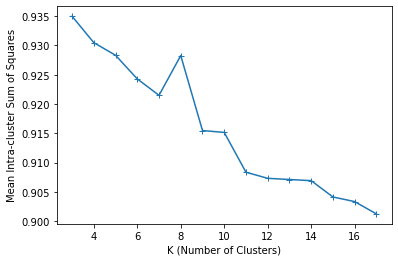

In [187]:
from Elbow import elbow_tuner

k_to_try = range(3, 18, 1)

intra_cluster_sum_of_squares = elbow_tuner(negative_X_test, k_to_try)

plt.plot(k_to_try, intra_cluster_sum_of_squares, '-+')
plt.xlabel('K (Number of Clusters)')
plt.ylabel('Mean Intra-cluster Sum of Squares')

In [188]:
kmeans_final = MiniBatchKMeans(n_clusters=11).fit(negative_X_test)
print_top_n_features(kmeans_final,ix_to_tokens,n=11)

Top tokens from cluster 0 (# of obs: 329)
['rice', 'fried', 'fried rice', 'ordered', 'good', 'pork', 'shrimp', 'chicken', 'came', 'sauce', 'like']
Top tokens from cluster 1 (# of obs: 1005)
['good', 'pretty', 'nice', 'really', 'pretty good', 'place', 'little', 'like', 'would', 'price', 'restaurant']
Top tokens from cluster 2 (# of obs: 715)
['chicken', 'good', 'ordered', 'fried', 'fried chicken', 'like', 'fries', 'sauce', 'got', 'place', 'dry']
Top tokens from cluster 3 (# of obs: 2199)
['us', 'order', 'minutes', 'get', 'said', 'asked', 'time', 'one', 'came', 'table', 'would']
Top tokens from cluster 4 (# of obs: 417)
['bad', 'good', 'service', 'place', 'never', 'like', 'really', 'go', 'one', 'even', 'come']
Top tokens from cluster 5 (# of obs: 488)
['pizza', 'crust', 'good', 'ordered', 'like', 'order', 'one', 'would', 'sauce', 'cheese', 'wings']
Top tokens from cluster 6 (# of obs: 743)
['burger', 'sandwich', 'fries', 'cheese', 'good', 'eggs', 'ordered', 'got', 'like', 'get', 'bacon']

In [183]:
(kmeans_final.labels_ == 24).sum()

0

In [184]:
kmeans_final.labels_ .shape

(11017,)

In [185]:
# list to store observations per cluster
obs_per_cluster = []
for cluster_id in range(24):
    obs_per_cluster.append( (kmeans_final.labels_ == cluster_id).sum() )

# convert into numpy array, which allows np.argsort() to work / speeds it up
# obs_per_cluster = np.array(obs_per_cluster)

# iterate through results of argsort() in reverse, to view number of observations in descending order
for cluster_id in reversed(np.argsort(obs_per_cluster)):
    print(cluster_id, obs_per_cluster[cluster_id])

1 3729
8 1926
3 1595
0 1149
2 758
7 542
4 508
6 420
5 390
22 0
9 0
10 0
23 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
11 0


In [186]:
np.argsort?

Signature: np.argsort(a, axis=-1, kind=None, order=None)
Docstring:
Returns the indices that would sort an array.

Perform an indirect sort along the given axis using the algorithm specified
by the `kind` keyword. It returns an array of indices of the same shape as
`a` that index data along the given axis in sorted order.

Parameters
----------
a : array_like
    Array to sort.
axis : int or None, optional
    Axis along which to sort.  The default is -1 (the last axis). If None,
    the flattened array is used.
kind : {'quicksort', 'mergesort', 'heapsort', 'stable'}, optional
    Sorting algorithm. The default is 'quicksort'. Note that both 'stable'
    and 'mergesort' use timsort under the covers and, in general, the
    actual implementation will vary with data type. The 'mergesort' option
    is retained for backwards compatibility.

    .. versionchanged:: 1.15.0.
       The 'stable' option was added.
order : str or list of str, optional
    When `a` is an array with fields define